# Cross Validation

Clean up train data:
- Remove duplicated images to avoid leak in cross-validation (154 detected => 162 related boxes removed)

Criteria for multi-labels stratification:
- MultiLabels (different WBC class per image)
- Image size
- BBx average surface ratio
- Image mean
- Image std

In [15]:
import sys
sys.path.append("../code/src")
import cdc
from cdc.common.utils import *
from cdc.common.constants import *

In [27]:
import glob, os, time, random, gc, sys, math, re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.8)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from imagededup.methods import PHash
from PIL import Image

In [28]:
print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("CDC", cdc.__version__)

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy 1.26.4
Pandas 2.2.2
CDC 1.0.0


In [29]:
DATA_HOME = "../data"
IMAGES_HOME = os.path.join(DATA_HOME, "images_cytologia")
SEEDS = [42]
seed_everything_now(SEEDS[0])

## Clean up train data
- Compute PHash and drop duplicated
- Drop boxes related to the detected duplicated

In [32]:
def generate_info(file):
    img_details = []
    phasher = PHash()
    for file in tqdm(files):
        img = Image.open(file)
        img_np = np.array(img)
        h, w, c = img_np.shape
        mean = np.mean(img_np)
        mean_c = np.mean(img_np, axis=(0,1))
        std = np.std(img_np)
        std_c = np.std(img_np, axis=(0,1))    
        filename = os.path.join(os.path.dirname(file).split("/")[-1], os.path.basename(file))            
        encoding_hash = phasher.encode_image(image_array=img_np)
        img_stats = (filename, h, w, c, mean, std, mean_c, std_c, encoding_hash)
        img_details.append(img_stats)
    return img_details

In [33]:
files = glob.glob(IMAGES_HOME + "/*.jpg")
print(len(files))
img_details_trustii = generate_info(files)
images_trustii_pd = pd.DataFrame(img_details_trustii, columns=["filename", "img_height", "img_width", "img_channel", "mean", "std", "mean_c", "std_c", "phash"])

69168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69168/69168 [23:52<00:00, 48.28it/s]


In [34]:
train_trustii_pd = pd.read_csv(os.path.join(DATA_HOME, "train.csv"))
test_trustii_pd = pd.read_csv(os.path.join(DATA_HOME, "test.csv"))
images_trustii_pd["NAME"] = images_trustii_pd["filename"].apply(lambda x: x.split("/")[-1])
images_trustii_pd["src"] = "none"
images_trustii_pd.loc[images_trustii_pd["NAME"].isin(train_trustii_pd["NAME"].unique()), "src"] = "train"
images_trustii_pd.loc[images_trustii_pd["NAME"].isin(test_trustii_pd["NAME"].unique()), "src"] = "test"
images_trustii_pd.groupby("src")["NAME"].count().reset_index()

,src,NAME
0,test,20751
1,train,48417


In [35]:
# Remove duplicated images in train dataset.
DUPLICATED_LEAK = []
images_trustii_pd["duplicates"] = images_trustii_pd.groupby("phash")["filename"].transform('count')
for duplicate in images_trustii_pd[images_trustii_pd["duplicates"]>1]["phash"].unique():
    duplicated_pd = images_trustii_pd[images_trustii_pd["phash"] == duplicate]
    if (duplicated_pd["src"].nunique() == 1) and (duplicated_pd["src"].unique()[0] == "train"):
        DUPLICATED_LEAK.extend([duplicated_pd["filename"].values[-1]])
print(len(DUPLICATED_LEAK))
images_trustii_pd = images_trustii_pd[~images_trustii_pd["filename"].isin(DUPLICATED_LEAK)].reset_index(drop=True)
print(images_trustii_pd.shape)
DUPLICATED_LEAK = []
images_trustii_pd["duplicates"] = images_trustii_pd.groupby("phash")["filename"].transform('count')
for duplicate in images_trustii_pd[images_trustii_pd["duplicates"]>1]["phash"].unique():
    duplicated_pd = images_trustii_pd[images_trustii_pd["phash"] == duplicate]
    if (duplicated_pd["src"].nunique() == 1) and (duplicated_pd["src"].unique()[0] == "train"):
        DUPLICATED_LEAK.extend([duplicated_pd["filename"].values[-1]])
print(len(DUPLICATED_LEAK))
images_trustii_pd = images_trustii_pd[~images_trustii_pd["filename"].isin(DUPLICATED_LEAK)].reset_index(drop=True)
print(images_trustii_pd.shape)

153
(69015, 12)
1
(69014, 12)


#### Create a dataset with labels

In [36]:
# Add labels
trustii_pd = images_trustii_pd.copy()
train_labels_pd = train_trustii_pd.copy()
print(train_labels_pd.shape, train_labels_pd["NAME"].nunique())
print(train_labels_pd["class"].unique())
test_pd = test_trustii_pd.copy()
print(test_pd.shape, test_pd["NAME"].nunique())
trustii_pd.groupby("src")["NAME"].count().reset_index()

(52748, 6) 48417
['PNN' 'MO' 'MM' 'LyB' 'LGL' 'Thromb' 'LLC' 'LAM3' 'EO' 'LY' 'BA' 'MoB'
 'LM' 'LH_lyAct' 'Lysee' 'Er' 'LF' 'LZMG' 'MBL' 'SS' 'PM' 'B' 'M']
(22689, 2) 20751


,src,NAME
0,test,20751
1,train,48263


In [37]:
# Remove labels for duplicated images found previously
train_labels_checks_pd = pd.merge(train_labels_pd, trustii_pd, on="NAME", how="left")
print(train_labels_checks_pd["src"].unique(), train_labels_checks_pd[train_labels_checks_pd["src"].isna()].shape)
train_labels_checks_pd = train_labels_checks_pd[~train_labels_checks_pd["src"].isna()].reset_index(drop=True)
print(train_labels_checks_pd["src"].unique(), train_labels_checks_pd[train_labels_checks_pd["src"].isna()].shape)

['train' nan] (162, 17)
['train'] (0, 17)


#### Check and fix bad bounding boxes (boundaries outside image)

In [40]:
def check_bbox(x1, y1, x2, y2, width, height):
    ret = 0
    p1, p2 = False, False 
    if (x1 >= 0) and (x1 < width) and (y1 >= 0) and (y1 < height):
        p1 = True
    if (x2 >= 0) and (x2 < width) and (y2 >= 0) and (y2 < height):
        p2 = True
    if (p1 and p2 and (x1 < x2) and (y1 < y2)):
        ret = 1
    return ret

def fix_bbox(x1, y1, x2, y2, width, height):
    x1 = np.clip(x1, 0, width-1)
    x2 = np.clip(x2, 0, width-1)
    y1 = np.clip(y1, 0, height-1)
    y2 = np.clip(y2, 0, height-1)
    return x1, y1, x2, y2

In [41]:
train_labels_checks_pd["is_bb_valid"] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: check_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1)
# 1000 BBs outside the image across 927 images
print(train_labels_checks_pd[train_labels_checks_pd["is_bb_valid"] != 1].shape, train_labels_checks_pd[train_labels_checks_pd["is_bb_valid"] != 1]["NAME"].nunique())
# Fix BBs boundaries
train_labels_checks_pd[["x1", "y1", "x2", "y2"]] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")
print(train_labels_checks_pd[train_labels_checks_pd["is_bb_valid"] != 1].shape)
# Checks it's really fixed.
train_labels_checks_pd["is_bb_safe"] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: check_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1)
print(train_labels_checks_pd[train_labels_checks_pd["is_bb_safe"] != 1].shape)
del train_labels_checks_pd["is_bb_safe"]
del train_labels_checks_pd["duplicates"]
# Add meta-data
train_labels_checks_pd["label"] = train_labels_checks_pd["class"].copy() 
train_labels_checks_pd["class"] = train_labels_checks_pd["class"].map(class_mapping_inv)
train_labels_checks_pd["x1"] = train_labels_checks_pd["x1"].astype(np.int32)
train_labels_checks_pd["x2"] = train_labels_checks_pd["x2"].astype(np.int32)
train_labels_checks_pd["y1"] = train_labels_checks_pd["y1"].astype(np.int32)
train_labels_checks_pd["y2"] = train_labels_checks_pd["y2"].astype(np.int32)
train_labels_checks_pd["img_channel"] = train_labels_checks_pd["img_channel"].astype(np.int32)
train_labels_checks_pd["img_width"] = train_labels_checks_pd["img_width"].astype(np.int32)
train_labels_checks_pd["img_height"] = train_labels_checks_pd["img_height"].astype(np.int32)
train_labels_checks_pd["bb_width"] = train_labels_checks_pd["x2"] - train_labels_checks_pd["x1"]
train_labels_checks_pd["bb_height"] = train_labels_checks_pd["y2"] - train_labels_checks_pd["y1"]
print(train_labels_checks_pd.shape)
# Save cleaned dataset
train_labels_checks_pd.to_parquet(os.path.join(DATA_HOME, "BB_cleaned_v1.parquet"))

/tmp/ipykernel_241381/1475822186.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_labels_checks_pd["is_bb_valid"] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: check_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1)


(1000, 18) 927


/tmp/ipykernel_241381/1475822186.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_labels_checks_pd[["x1", "y1", "x2", "y2"]] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")


(1000, 18)


/tmp/ipykernel_241381/1475822186.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_labels_checks_pd["is_bb_safe"] = train_labels_checks_pd[["x1", "y1", "x2", "y2", "img_width", "img_height"]].apply(lambda x: check_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1)


(0, 19)
(52586, 20)


In [42]:
train_labels_checks_pd.head()

,NAME,x1,y1,x2,y2,class,filename,img_height,img_width,img_channel,mean,std,mean_c,std_c,phash,src,is_bb_valid,label,bb_width,bb_height
0,cf7734a2-b.jpg,99,88,266,276,0,images_cytologia/cf7734a2-b.jpg,366,360,3,186.866968,40.210733,"[214.04042956891317, 174.20805251973286, 172.3...","[36.24750306829261, 45.27386086538642, 19.4367...",b1c8cade72664d1b,train,1,PNN,167,188
1,e6a3b579-0.jpg,92,78,272,284,2,images_cytologia/e6a3b579-0.jpg,366,360,3,186.333209,46.419948,"[211.73120825743777, 173.09028536733456, 174.1...","[44.654740278334664, 54.55719440906058, 22.928...",b3c5ca1835939e7c,train,1,MO,180,206
2,60f95776-f.jpg,110,103,251,251,16,images_cytologia/60f95776-f.jpg,363,360,3,183.819758,46.115635,"[203.36148607284971, 173.0988445056627, 174.99...","[48.516774744245396, 53.59788811642493, 24.056...",f299d9ee27b3c030,train,1,MM,141,148
3,0894e581-c.jpg,112,121,248,262,10,images_cytologia/0894e581-c.jpg,370,368,3,196.577921,49.441360,"[209.5364864864865, 187.23958578143362, 192.95...","[50.270979912661744, 62.316497255105034, 25.58...",f5d78c2963d5d301,train,1,LyB,136,141
4,3998a979-3.jpg,94,86,276,281,2,images_cytologia/3998a979-3.jpg,366,360,3,193.003620,48.225551,"[216.3316029143898, 183.2514875531269, 179.427...","[48.00103055632063, 57.401300993258715, 23.547...",f498d86331af56c9,train,1,MO,182,195


## Cross-Validation

In [44]:
class Config:
    seed = SEEDS[0]
    folds = 4
    folds_seed = seed
    label_col = LABEL
    mean_col = "mean_bin"
    std_col = "std_bin"
    surface_col = "surface_bin"
    surface_ratio_col = "bb_avg_surface_ratio_bin"

config = Config

In [67]:
# Reload cleaned dataset
train_pd = pd.read_parquet(os.path.join(DATA_HOME, "BB_cleaned_v1.parquet"))
# Group BBx by image to generate multilabel
results = []
train_pd["img_surface"] = train_pd["img_width"] * train_pd["img_height"]
train_pd["bb_surface"] = train_pd["bb_width"] * train_pd["bb_height"]
train_pd["bb_surface_ratio"] = train_pd["bb_surface"]*100./train_pd["img_surface"]
train_pd["bb"] = train_pd[["x1", "x2", "y1", "y2", "class"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4]), axis=1)
train_pd = train_pd.groupby(["filename", "NAME", "src", "img_width", "img_height", "phash", "mean", "std", "img_surface"])[["class", "bb_surface_ratio", "bb"]].agg(classes=('class', list), bb_avg_surface_ratio=('bb_surface_ratio', "mean"), bbx=('bb', list)).reset_index()
for idx, row in train_pd.iterrows():
    filename = row["filename"]
    name = row["NAME"]
    img_width = row["img_width"]
    img_height = row["img_height"]
    phash = row["phash"]
    mean = row["mean"]
    std = row["std"]
    src = row["src"]
    img_surface = row["img_surface"]
    classes = row["classes"]
    total_classes = len(classes)
    bb_avg_surface_ratio = row["bb_avg_surface_ratio"]
    bbx = row["bbx"]
    total_bbx = len(bbx)
    labels = np.zeros(len(class_mapping), np.int32)
    for c in classes:
        labels[c] = 1
    results.append((filename, name, src, img_width, img_height, phash, mean, std, img_surface, bb_avg_surface_ratio, total_classes, bbx, total_bbx) + tuple(labels))
train_pd = pd.DataFrame(results, columns=["filename", "NAME", "src", "img_width", "img_height", "phash", "mean", "std", "img_surface", "bb_avg_surface_ratio", "classes", "bbx", "bbs"] + list(class_mapping.values()))
# Add multilabel
labels_pd = []
for idx, row in train_pd.iterrows():
    uid = row["filename"]
    label_list = []    
    for name, label in class_mapping_inv.items():
        if row[name] == 1:
            label_list.append(str(label))
    labels_pd.append((uid, "|".join(label_list)))
labels_pd = pd.DataFrame(labels_pd, columns=["filename", LABEL])
train_pd = pd.merge(train_pd, labels_pd, on="filename", how="inner")
train_pd["surface_bin"] = pd.cut(train_pd["img_surface"], bins=5, labels=[0,1,2,3,4])
train_pd["bb_avg_surface_ratio_bin"] = pd.cut(train_pd["bb_avg_surface_ratio"], bins=5, labels=[0,1,2,3,4])

print(train_pd.shape)
train_pd["mean_bin"] = pd.cut(train_pd["mean"], bins=5, labels=[0,1,2,3,4])
train_pd["std_bin"] = pd.cut(train_pd["std"], bins=4, labels=[0,1,2,3])

/tmp/ipykernel_241381/293418853.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_pd["bb"] = train_pd[["x1", "x2", "y1", "y2", "class"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4]), axis=1)


(48263, 39)


In [68]:
train_pd.head()

,filename,NAME,src,img_width,img_height,phash,mean,std,img_surface,bb_avg_surface_ratio,...,MoB,LH_lyAct,LM,LZMG,SS,multilabel,surface_bin,bb_avg_surface_ratio_bin,mean_bin,std_bin
0,images_cytologia/00008cef-c.jpg,00008cef-c.jpg,train,368,370,b787daa066b8d247,209.093224,42.264992,136160,16.521739,...,0,0,0,0,0,0,0,1,4,2
1,images_cytologia/00010aae-3.jpg,00010aae-3.jpg,train,352,357,b4b0c86c26fe0f1f,186.580450,48.086801,125664,24.112713,...,0,0,0,0,0,3,0,1,2,2
2,images_cytologia/00016779-d.jpg,00016779-d.jpg,train,352,357,e9ca8c4c60943fbf,188.245209,47.232337,125664,18.382353,...,0,0,0,0,0,3,0,1,3,2
3,images_cytologia/0003ab57-1.jpg,0003ab57-1.jpg,train,368,369,f6c4d95d63ec8419,198.827933,44.390070,135792,16.235124,...,0,0,0,0,0,0,0,1,3,2
4,images_cytologia/000a7dc3-d.jpg,000a7dc3-d.jpg,train,368,369,a7168d7522a59f9c,204.639925,45.881671,135792,7.586603,...,0,0,0,0,0,10,0,0,3,2


In [69]:
train_pd[train_pd["classes"] > 1][["filename", "multilabel", "mean_bin", "std_bin"]].head()

,filename,multilabel,mean_bin,std_bin
33,images_cytologia/00300172-c.jpg,9|11,2,2
62,images_cytologia/005295fa-e.jpg,7|8,3,3
84,images_cytologia/007079b5-e.jpg,9|11,2,3
108,images_cytologia/00947c65-8.jpg,8,2,3
114,images_cytologia/00a10b20-b.jpg,11,3,2


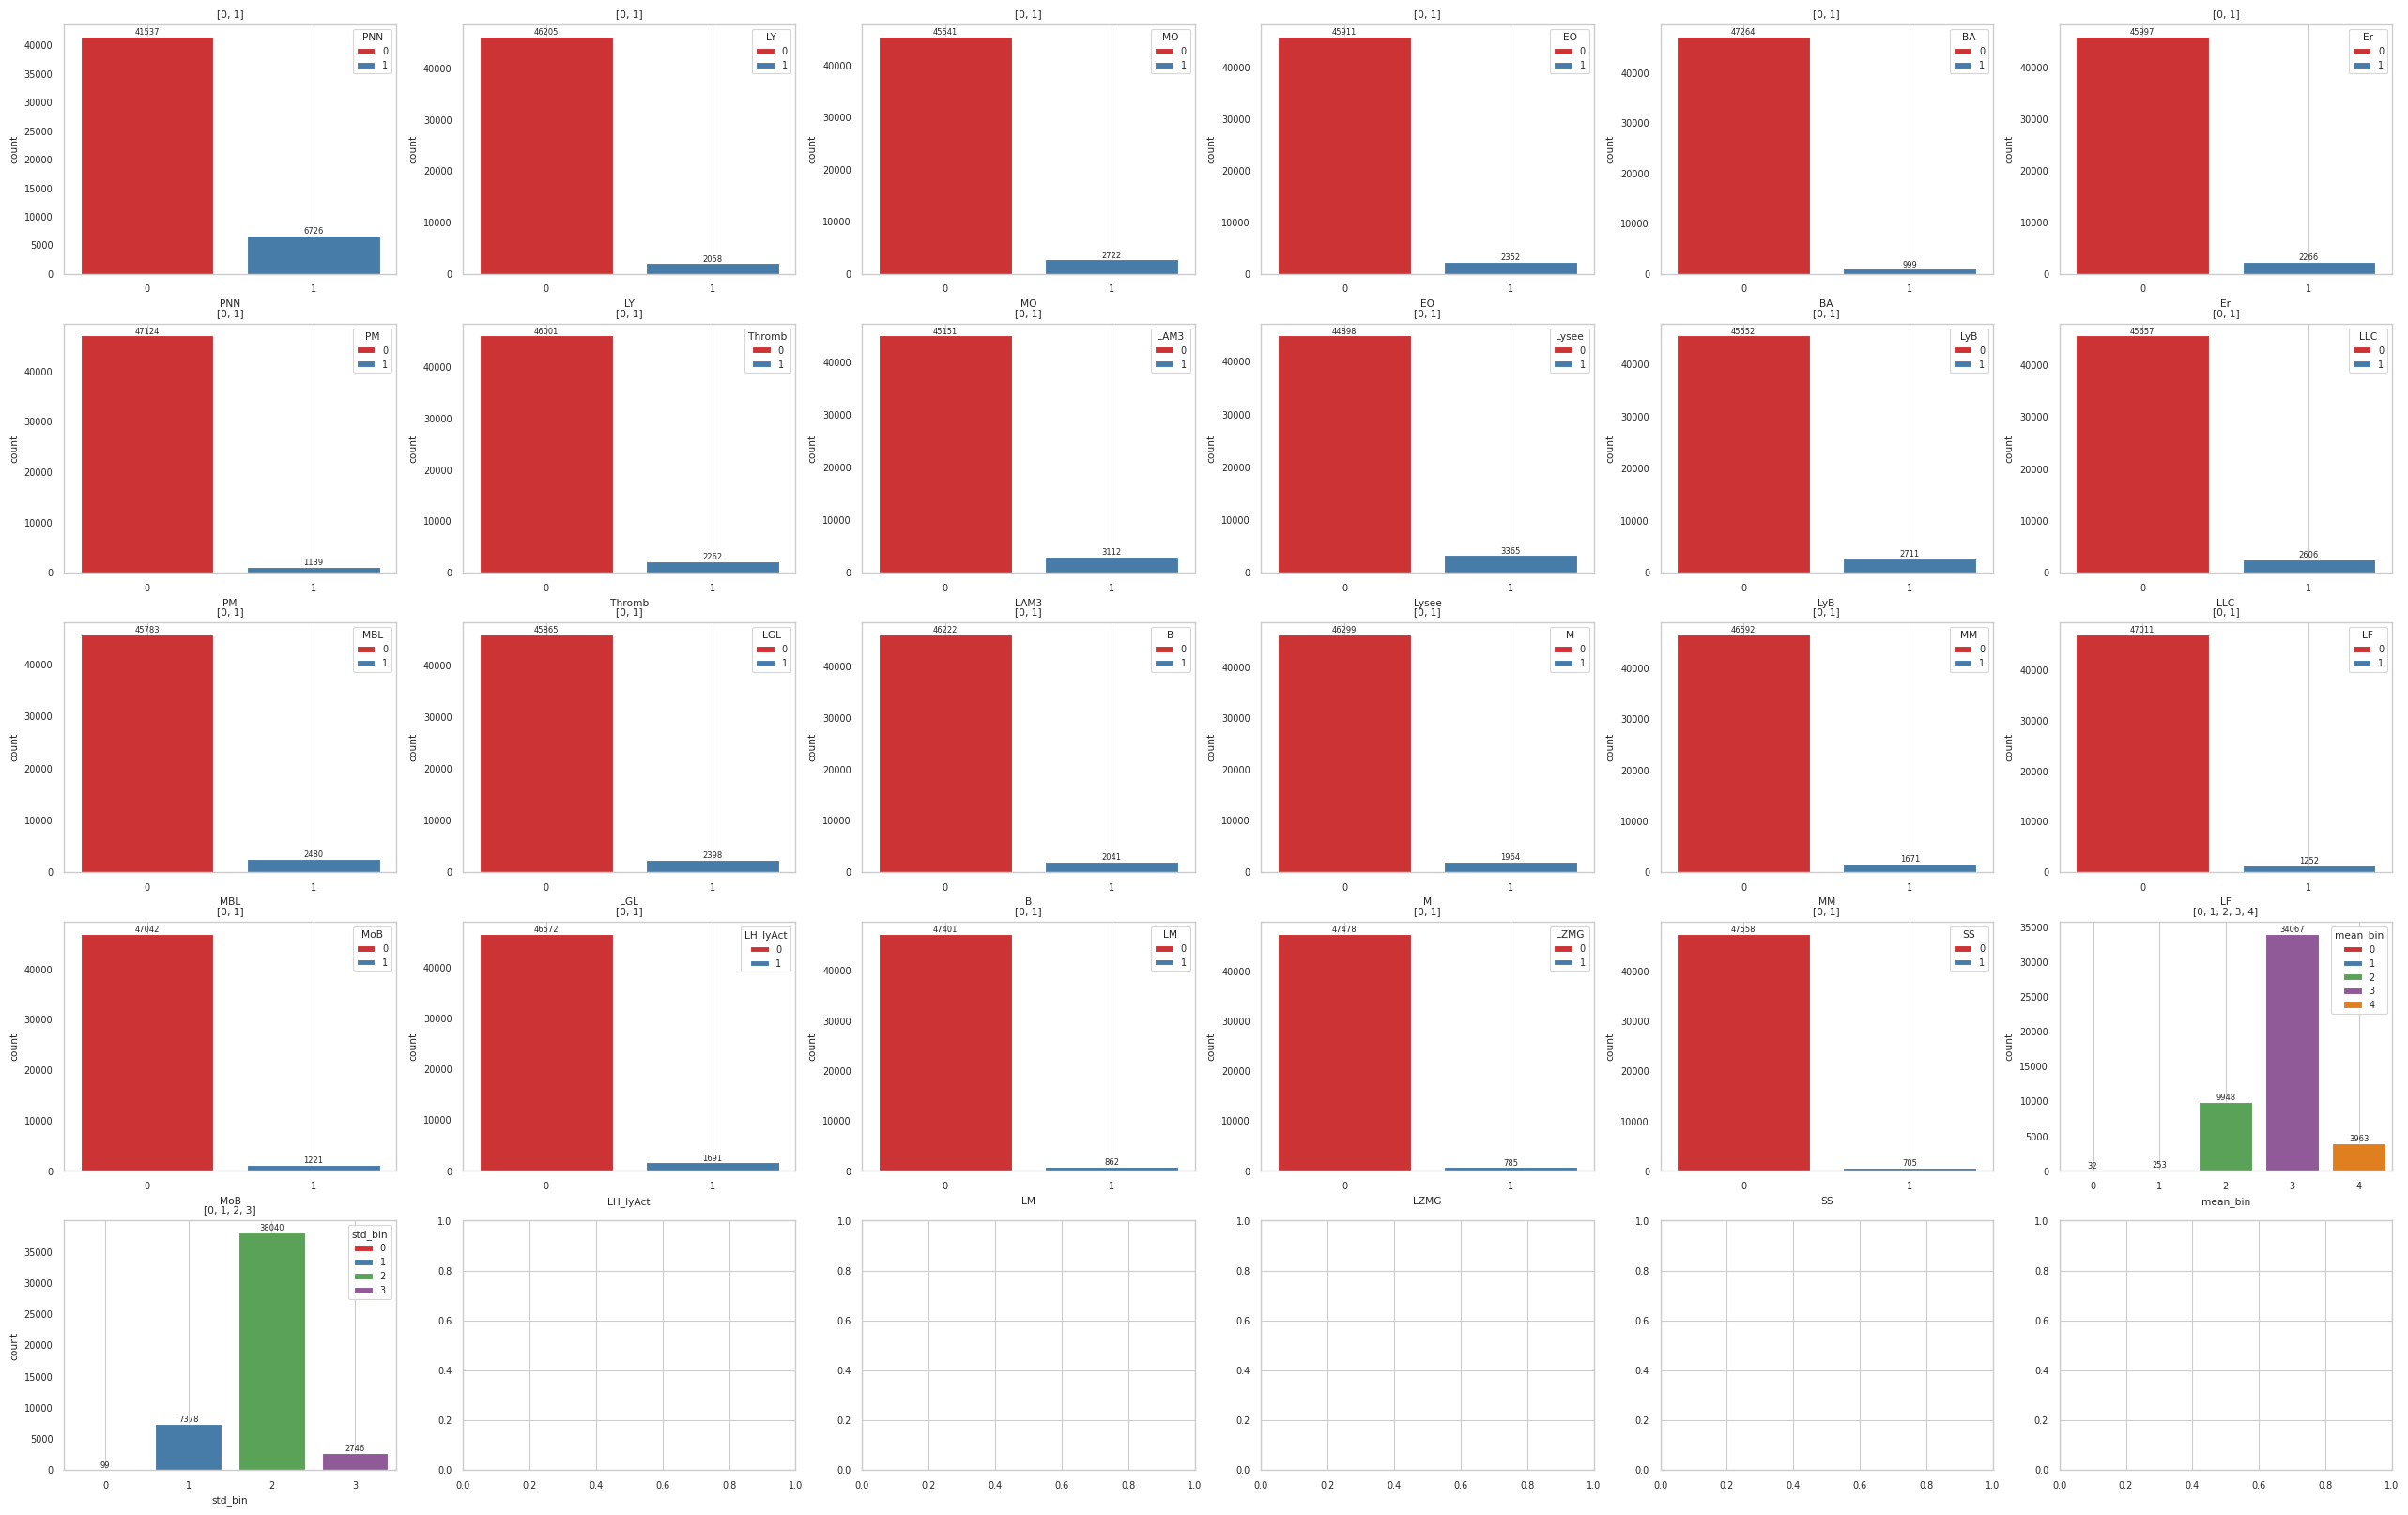

In [70]:
fig, ax = plt.subplots(5, 6, figsize=(32,20))
k = 0
for c in [k for k in train_pd.columns if k in class_mapping.values()] + ["mean_bin", "std_bin"]:
    j = k%6
    i = k//6
    d = sns.countplot(x=c, data=train_pd, ax=ax[i, j], hue=c, palette = "Set1")
    for m in ax[i, j].containers:
        ax[i, j].bar_label(m, fmt='%d', fontsize=6)
    d = ax[i, j].set_title("%s" % (sorted(train_pd[c].unique())))
    d = ax[i, j].grid()
    k = k+1
d = plt.show()

## Cross Validation

In [71]:
# Multilabels stratification
statify_cols = list(class_mapping.values())
if config.surface_col is not None:
    statify_cols = statify_cols + [config.surface_col]
if config.surface_ratio_col is not None:
    statify_cols = statify_cols + [config.surface_ratio_col]         
if config.mean_col is not None:
    statify_cols = statify_cols + [config.mean_col]
if config.std_col is not None:
    statify_cols = statify_cols + [config.std_col]   
stratify = train_pd[statify_cols]
skf = MultilabelStratifiedKFold(n_splits=config.folds, shuffle=True, random_state=config.folds_seed)

print("Stratification:", skf)
for i, (_, val_index) in enumerate(skf.split(train_pd, stratify)):
    train_pd.loc[val_index, "fold_s%d"%config.folds_seed] = i
train_pd["fold_s%d"%config.folds_seed] = train_pd["fold_s%d"%config.folds_seed].astype(np.int16)

Stratification: MultilabelStratifiedKFold(n_splits=4, random_state=42, shuffle=True)


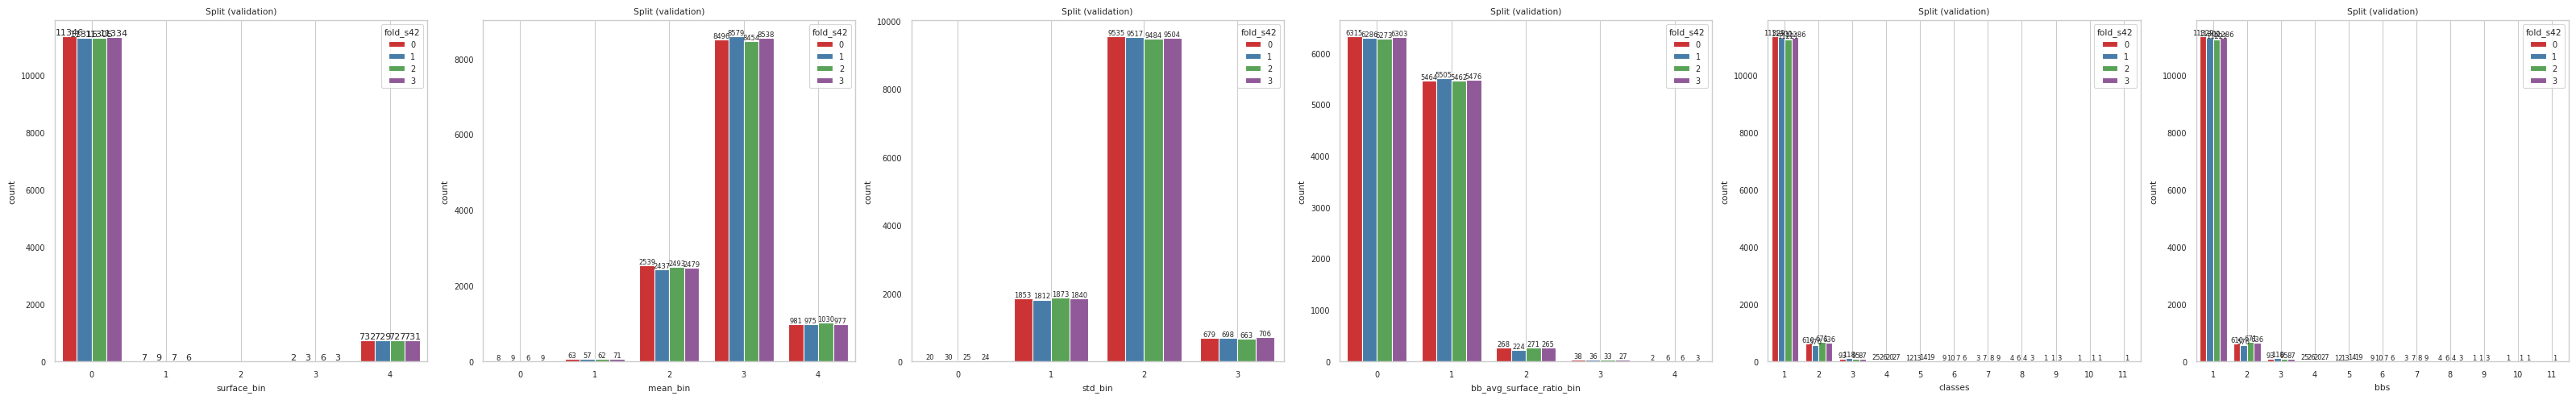

In [72]:
seed_ = config.folds_seed
fig, ax = plt.subplots(1, 6, figsize=(32,5))
d = sns.countplot(x=config.surface_col, data=train_pd, hue="fold_s%d" % seed_, ax=ax[0], palette = "Set1")
for i in ax[0].containers:
    ax[0].bar_label(i,fmt='%d', fontsize=8)
d = ax[0].set_title("Split (validation)")
d = ax[0].grid()
d = sns.countplot(x=config.mean_col, data=train_pd, hue="fold_s%d" % seed_, ax=ax[1], palette = "Set1")
for i in ax[1].containers:
    ax[1].bar_label(i,fmt='%d', fontsize=6)
d = ax[1].set_title("Split (validation)")
d = ax[1].grid()
d = sns.countplot(x=config.std_col, data=train_pd, hue="fold_s%d" % seed_, ax=ax[2], palette = "Set1")
for i in ax[2].containers:
    ax[2].bar_label(i,fmt='%d', fontsize=6)
d = ax[2].set_title("Split (validation)")
d = ax[2].grid()
d = sns.countplot(x=config.surface_ratio_col, data=train_pd, hue="fold_s%d" % seed_, ax=ax[3], palette = "Set1")
for i in ax[3].containers:
    ax[3].bar_label(i,fmt='%d', fontsize=6)
d = ax[3].set_title("Split (validation)")
d = ax[3].grid()
plt.tight_layout()
d = sns.countplot(x="classes", data=train_pd, hue="fold_s%d" % seed_, ax=ax[4], palette = "Set1")
for i in ax[4].containers:
    ax[4].bar_label(i,fmt='%d', fontsize=6)
d = ax[4].set_title("Split (validation)")
d = ax[4].grid()
d = sns.countplot(x="bbs", data=train_pd, hue="fold_s%d" % seed_, ax=ax[5], palette = "Set1")
for i in ax[5].containers:
    ax[5].bar_label(i,fmt='%d', fontsize=6)
d = ax[5].set_title("Split (validation)")
d = ax[5].grid()
plt.tight_layout()
plt.show()

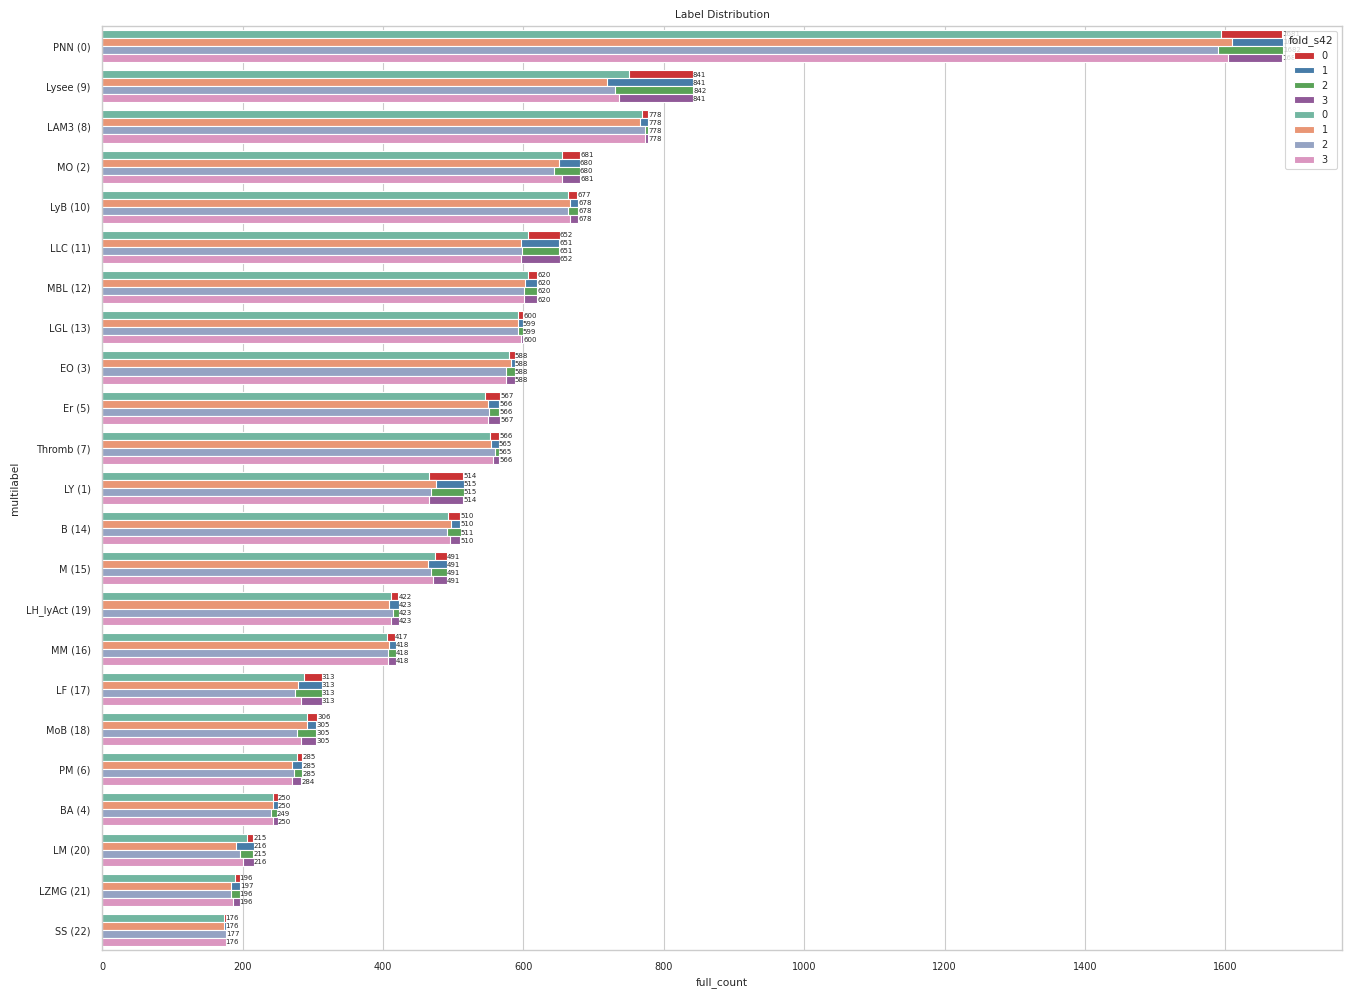

In [73]:
counts_pd = []
for fold in range(config.folds):
  train = train_pd[train_pd["fold_s%d" % seed_] != fold]
  valid = train_pd[train_pd["fold_s%d" % seed_] == fold]

  unique_counts = {}
  for lbl in class_labels:
      unique_counts[lbl] = len(valid[valid[LABEL] == lbl])
  full_counts = {}
  for lbl in class_labels:
      count = 0
      for row_label in valid[LABEL]:
          if lbl in row_label.split('|'): count += 1
      full_counts[lbl] = count
  counts_pd_ = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
  counts_pd_ = np.array(sorted(counts_pd_, key=lambda x:-x[1]))
  counts_pd_ = pd.DataFrame(counts_pd_, columns=[LABEL, 'full_count', 'unique_count'], dtype='int')
  counts_pd_[LABEL] = counts_pd_[LABEL].map(class_mapping_)
  counts_pd_["fold_s%d"%seed_] = fold
  counts_pd.append(counts_pd_)
counts_pd = pd.concat(counts_pd, ignore_index=True)

f, ax = plt.subplots(1, 1, figsize=(16, 12))
sns.barplot(x="full_count", y=LABEL, data=counts_pd, order=counts_pd[LABEL].values, palette="Set1", orient = 'h', hue="fold_s%d"%seed_, ax=ax)
for i in ax.containers:
    ax.bar_label(i,fmt='%d', fontsize=5)
sns.barplot(x="unique_count", y=LABEL, data=counts_pd, order=counts_pd[LABEL].values, palette="Set2", orient = 'h', hue="fold_s%d"%seed_, ax=ax)
ax.set_title("Label Distribution")
d = plt.show()

Fold 0, Train/valid intersect: []


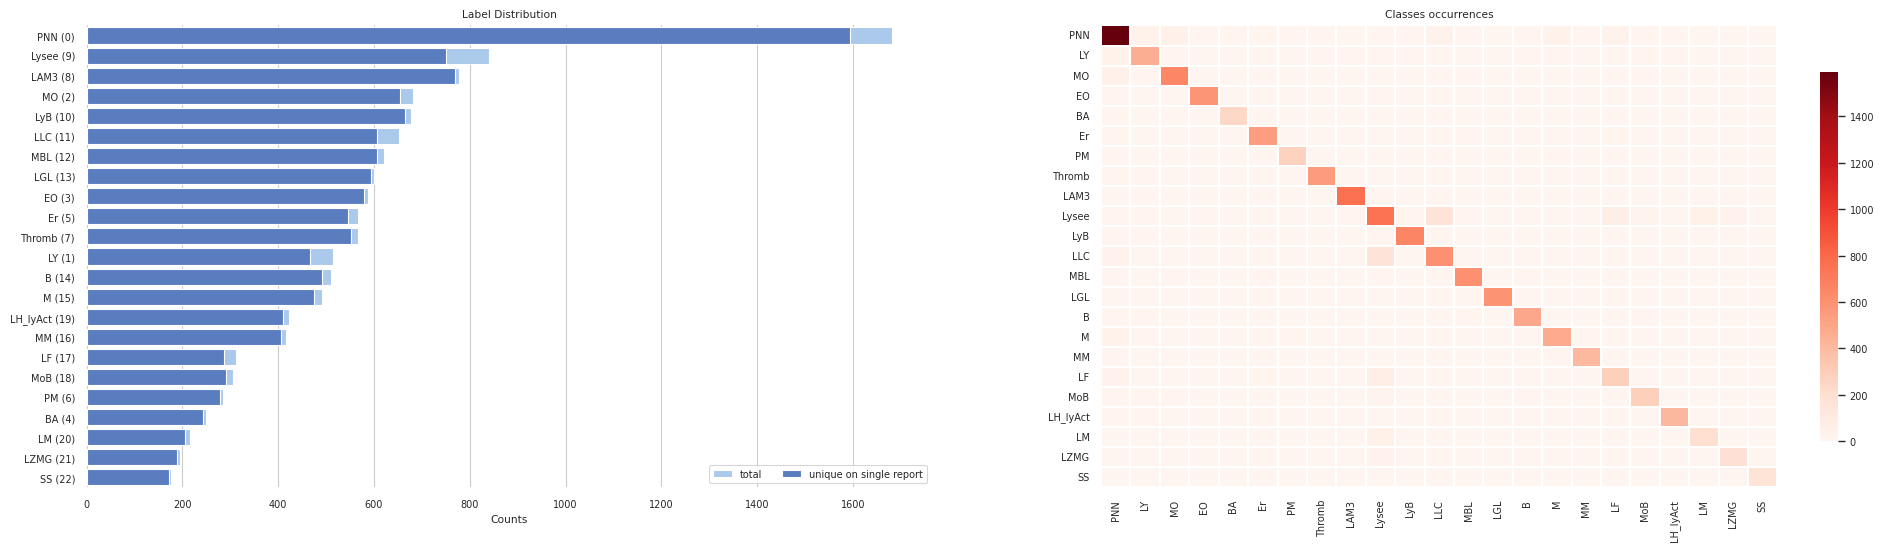

Fold 1, Train/valid intersect: []


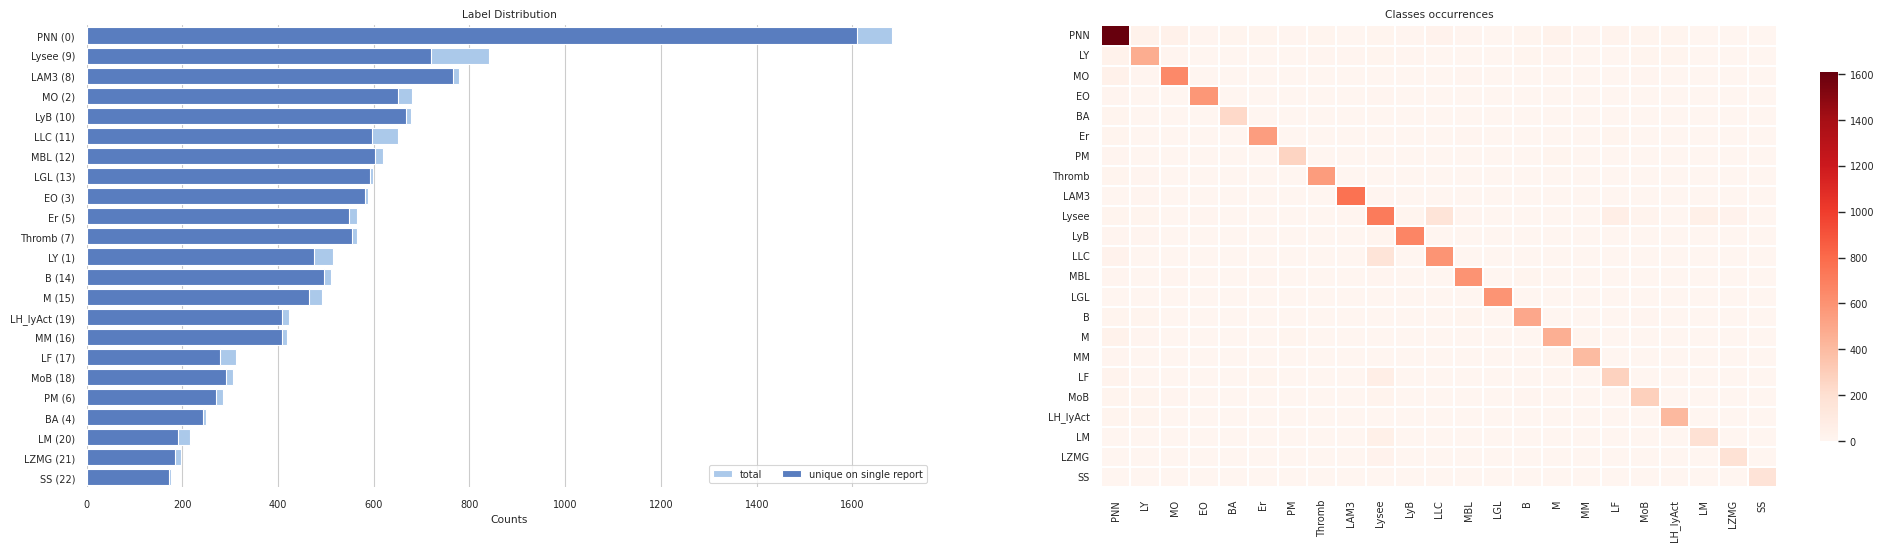

Fold 2, Train/valid intersect: []


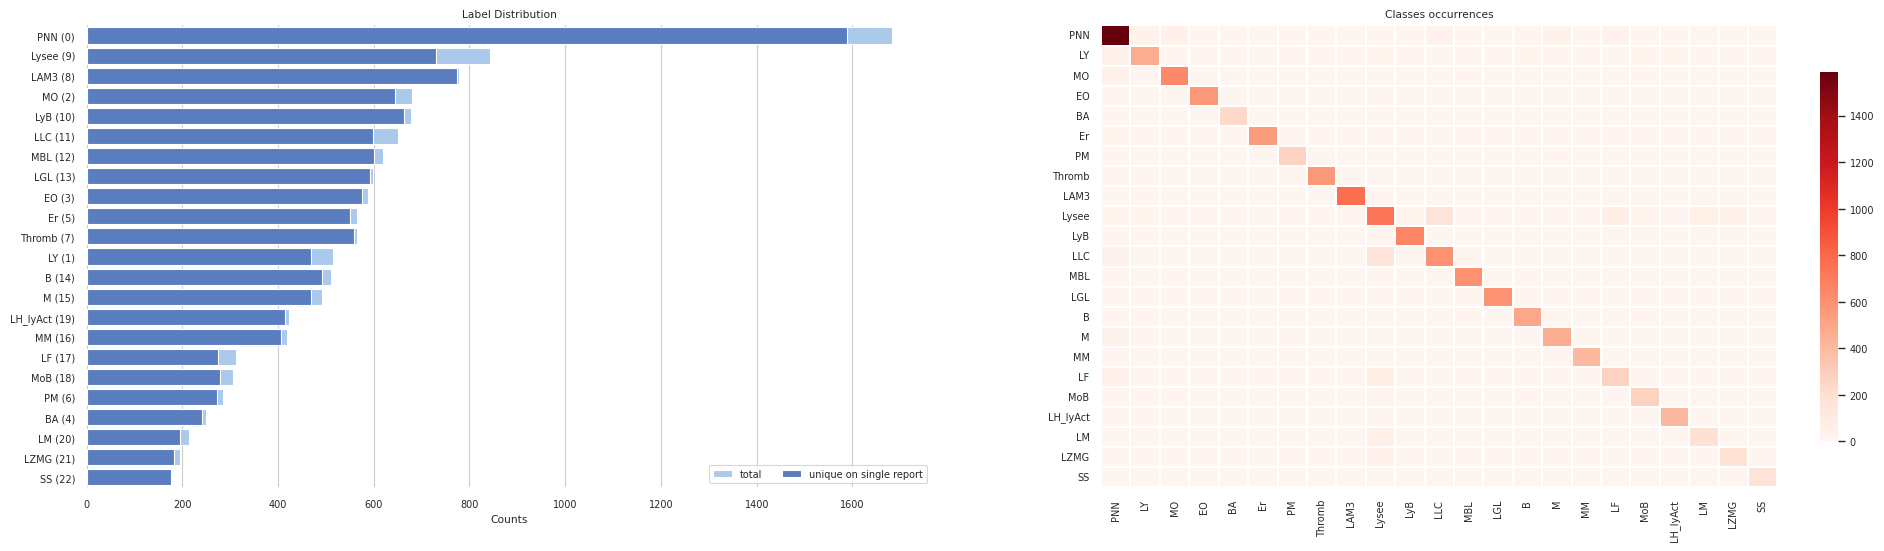

Fold 3, Train/valid intersect: []


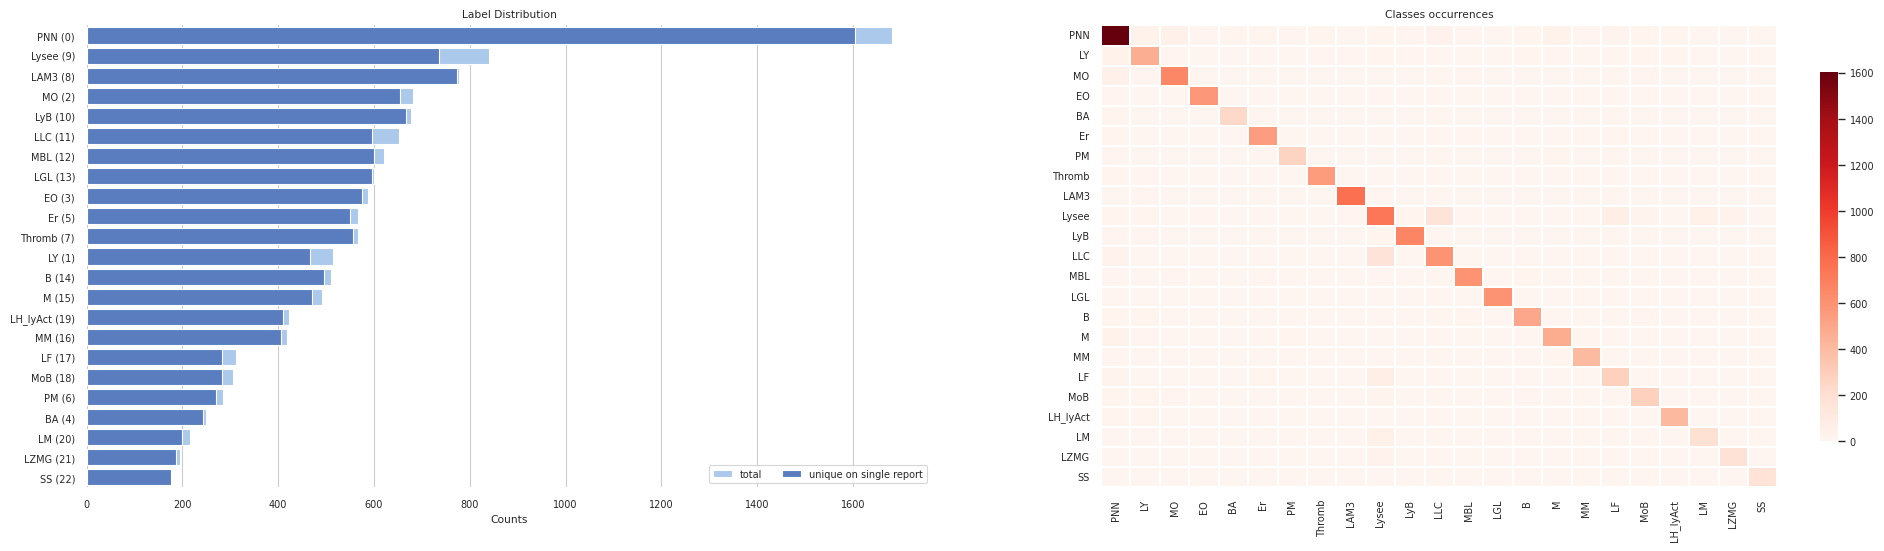

In [74]:
for fold in range(config.folds):
  train = train_pd[train_pd["fold_s%d" % seed_] != fold]
  valid = train_pd[train_pd["fold_s%d" % seed_] == fold]
  print("Fold %d, Train/valid intersect:"%fold , np.intersect1d(train["filename"].unique(), valid["filename"].unique()))

  unique_counts = {}
  for lbl in class_labels:
      unique_counts[lbl] = len(valid[valid[LABEL] == lbl])
  full_counts = {}
  for lbl in class_labels:
      count = 0
      for row_label in valid[LABEL]:
          if lbl in row_label.split('|'): count += 1
      full_counts[lbl] = count
  counts_pd = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
  counts_pd = np.array(sorted(counts_pd, key=lambda x:-x[1]))
  counts_pd = pd.DataFrame(counts_pd, columns=[LABEL, 'full_count', 'unique_count'], dtype='int')
  counts_pd[LABEL] = counts_pd[LABEL].map(class_mapping_)

  f, ax = plt.subplots(1, 2, figsize=(24, 6))
  sns.set_color_codes("pastel")

  sns.barplot(x="full_count", y=LABEL, data=counts_pd, order=counts_pd[LABEL].values, label="total", color="b", orient = 'h', ax=ax[0])

  sns.set_color_codes("muted")

  sns.barplot(x="unique_count", y=LABEL, data=counts_pd, order=counts_pd[LABEL].values, label="unique on single report", color="b", orient = 'h', ax=ax[0])

  ax[0].set_title("Label Distribution")
  # Add a legend and informative axis label
  ax[0].legend(ncol=2, loc="lower right", frameon=True)
  ax[0].set(ylabel="", xlabel="Counts")
  sns.despine(left=True, bottom=True)

  df_labels = train_pd[class_names]
  coocc = df_labels.T.dot(df_labels)

  for i, (k, v) in enumerate(class_mapping_.items()): coocc.iloc[i,i] = int(counts_pd["unique_count"][counts_pd[LABEL] == v].values[0])
  sns.heatmap(coocc, cmap="Reds", linewidth=0.3, cbar_kws={"shrink": .8}, ax=ax[1])
  d = ax[1].set_title('Classes occurrences')
  d = plt.show()

In [75]:
train_pd.to_parquet(os.path.join(DATA_HOME, "cv%d_seed%d_%s.parquet"%(config.folds, config.folds_seed, config.label_col)))